# Create Tabula File

In [1]:
import scanpy as sc

In [5]:
new_tabula_ad = sc.read("/lfs/local/0/yanay/uce_temp/new_tabula_sapiens_ep_8_sn_2013249_nlayers_33_sample_size_1024.h5ad")
new_tabula_ad

AnnData object with n_obs × n_vars = 1194952 × 19567
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'sample', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'n_genes'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'n_cells'
    obsm: 'X_uce'

In [6]:
new_tabula_ad.obs = new_tabula_ad.obs[["tissue", "cell_ontology_class"]]

In [7]:
new_tabula_ad

AnnData object with n_obs × n_vars = 1194952 × 19567
    obs: 'tissue', 'cell_ontology_class'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'n_cells'
    obsm: 'X_uce'

In [8]:
sc.pp.highly_variable_genes(new_tabula_ad, n_top_genes=5000, subset=True, flavor="seurat_v3", batch_key="tissue")

In [19]:
new_tabula_ad.X = new_tabula_ad.X.toarray()

In [20]:
new_tabula_ad.write("/lfs/local/0/yanay/new_tabula_HVG_uce_decoder.h5ad")

In [24]:
new_tabula_ad.X.sum(1).mean()

27083.873

In [22]:
new_tabula_ad.var_names

Index(['TSPAN6', 'TNMD', 'FGR', 'CFH', 'LAS1L', 'CFTR', 'CD99', 'MAD1L1',
       'TMEM176A', 'NDUFAF7',
       ...
       'DUS4L-BCAP29', 'F8A2', 'F8A1', 'CTAGE4', 'H2AC18', 'H2AC19', 'PPIAL4C',
       'PPIAL4D', 'CTAGE8', 'FAM153B'],
      dtype='object', name='index', length=5000)

# Inspect validation set

Decode expression from a different dataset

In [45]:
c19_ad = sc.read("/lfs/local/0/yanay/uce_temp/c19_blood_atlas_uce_decoded_adata.h5ad")
c19_ad

AnnData object with n_obs × n_vars = 836148 × 16700
    obs: 'Source', 'GEX_region', 'cluster', 'cluster_source', 'minor_subset', 'minor_subset_source', 'major_subset', 'major_subset_source', 'cell_type_source', 'donor_id', 'scRNASeq_sample_ID', 'Age', 'Hospitalstay', 'TimeSinceOnset', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_clone_count', 'TCR_clone_proportion', 'BCR_total_mut_HC', 'BCR_clonal_abundance_HC', 'BCR_total_mut_LC', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'cell_type_original', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'n_genes'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'

In [52]:
from scipy.special import expit
zi_probs = expit(c19_ad.obsm["decoded_dropouts"])

In [53]:
means = (1-zi_probs) * c19_ad.obsm["decoded_rates"]

In [54]:
c19_decoded_ad = sc.AnnData(means)
c19_decoded_ad.obs = c19_ad.obs
c19_decoded_ad.obsm["X_uce"] = c19_ad.obsm["X_uce"]

In [56]:
c19_decoded_ad.var_names = new_tabula_ad.var_names

In [57]:
sc.pp.pca(c19_decoded_ad)

/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


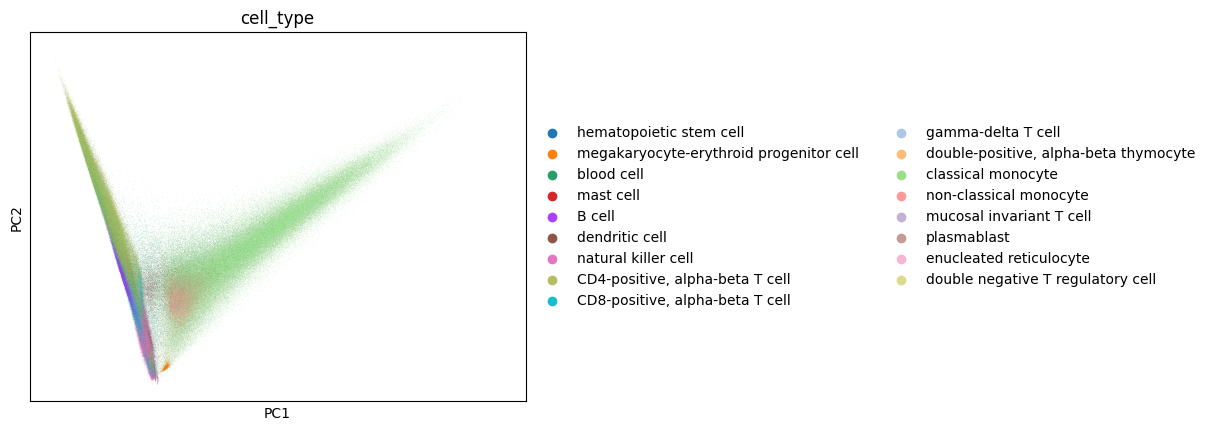

In [58]:
sc.pl.pca(c19_decoded_ad, color="cell_type")

In [59]:
c19_decoded_ad.obs["cell_type"].value_counts()

CD4-positive, alpha-beta T cell            269661
classical monocyte                         213697
CD8-positive, alpha-beta T cell            106025
natural killer cell                         70299
blood cell                                  52444
B cell                                      44256
non-classical monocyte                      33172
gamma-delta T cell                           9580
dendritic cell                               8959
plasmablast                                  8596
double-positive, alpha-beta thymocyte        6561
double negative T regulatory cell            4557
mucosal invariant T cell                     4541
hematopoietic stem cell                      1868
megakaryocyte-erythroid progenitor cell      1563
enucleated reticulocyte                       304
mast cell                                      65
Name: cell_type, dtype: int64

In [60]:
sc.tl.rank_genes_groups(c19_decoded_ad, groupby="cell_type", groups=["B cell"])

/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


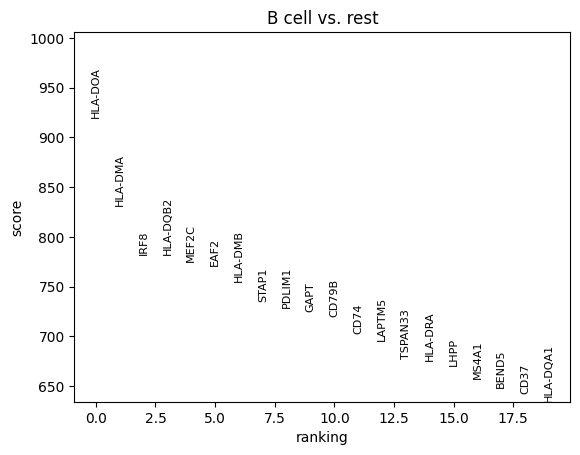

In [61]:
sc.pl.rank_genes_groups(c19_decoded_ad, groupby="cell_type", groups=["B cell"])

In [63]:
sc.tl.rank_genes_groups(c19_decoded_ad, groupby="cell_type", groups=["CD4-positive, alpha-beta T cell"])

/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


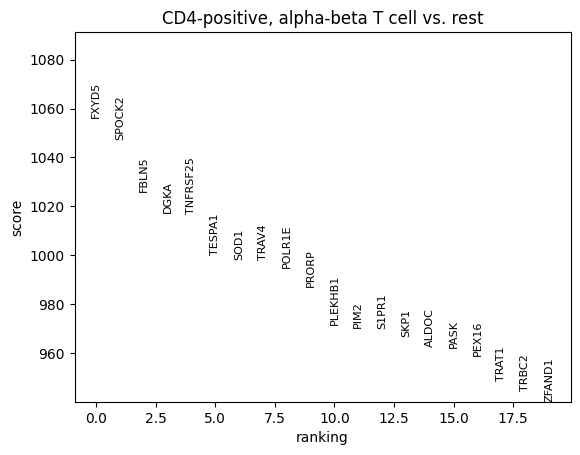

In [64]:
sc.pl.rank_genes_groups(c19_decoded_ad, groupby="cell_type", groups=["CD4-positive, alpha-beta T cell"])

In [65]:
sc.tl.rank_genes_groups(c19_decoded_ad, groupby="cell_type", groups=["CD8-positive, alpha-beta T cell"])

/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


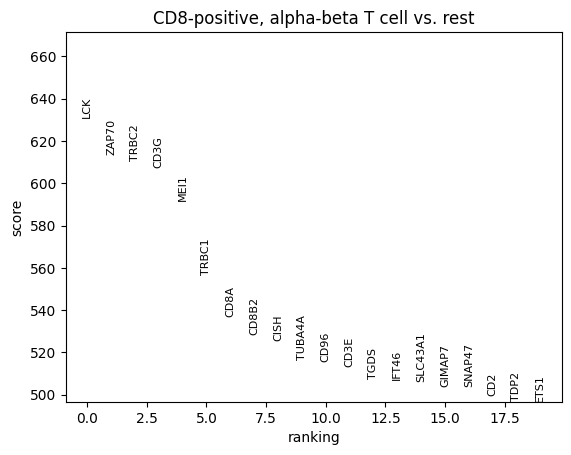

In [66]:
sc.pl.rank_genes_groups(c19_decoded_ad, groupby="cell_type", groups=["CD8-positive, alpha-beta T cell"])

In [70]:
sc.pp.neighbors(c19_decoded_ad)

In [71]:
sc.tl.umap(c19_decoded_ad)

/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


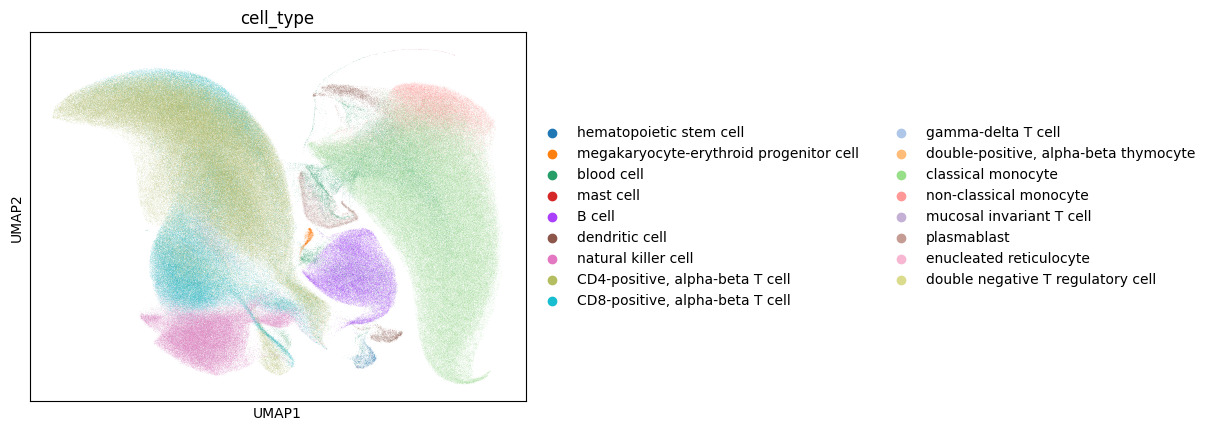

In [72]:
sc.pl.umap(c19_decoded_ad, color="cell_type")

# Compare Actual Expression vs Decoded Expression

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [105]:
keep_names = c19_ad.var_names.intersection(new_tabula_ad.var_names)

In [106]:
actual_expression = c19_ad[:, keep_names].X.toarray()

In [107]:
means_same_names = c19_decoded_ad[:, keep_names].X.toarray()

In [133]:
all_rs = []
for i in range(len(keep_names)):
    all_rs.append(np.corrcoef(x=means_same_names[:, i], y=actual_expression[:, i])[1, 0])

In [134]:
pd.Series(all_rs).describe()

count    4223.000000
mean        0.139603
std         0.160129
min        -0.089997
25%         0.021600
50%         0.080787
75%         0.195367
max         0.841345
dtype: float64

<Axes: ylabel='Density'>

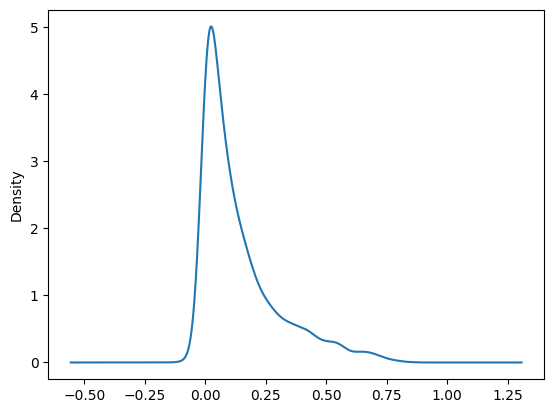

In [135]:
pd.Series(all_rs).plot.kde()

<Axes: >

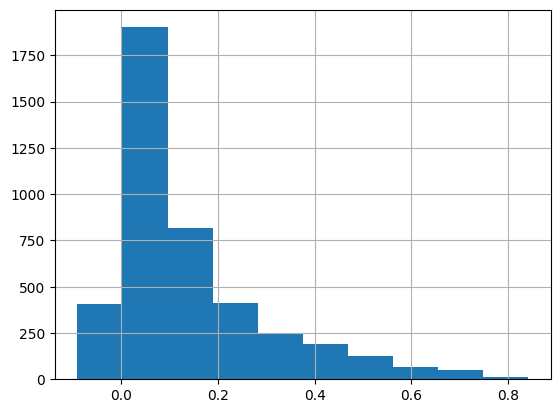

In [136]:
pd.Series(all_rs).hist()

# Average across cell types since noise is high

In [140]:
from tqdm.auto import tqdm
cts_to_rs = {}
for ct in tqdm(c19_ad.obs["cell_type"].unique()):
    ct_idx = np.where(c19_ad.obs["cell_type"] == ct)[0]
    
    average_expression_decoded = means_same_names[ct_idx].mean(0)
    average_expression_real = actual_expression[ct_idx].mean(0)
    
    cts_to_rs[ct] = np.corrcoef(x=average_expression_decoded, y=average_expression_real)[1, 0]

  0%|          | 0/17 [00:00<?, ?it/s]

In [142]:
ct_corr_df = pd.DataFrame(cts_to_rs.items())
ct_corr_df

,0,1
0,natural killer cell,0.941797
1,"CD8-positive, alpha-beta T cell",0.948589
2,blood cell,0.837394
3,non-classical monocyte,0.943395
4,classical monocyte,0.873928
5,"CD4-positive, alpha-beta T cell",0.957132
6,B cell,0.938284
7,mucosal invariant T cell,0.936383
8,plasmablast,0.708787
9,double negative T regulatory cell,0.944946


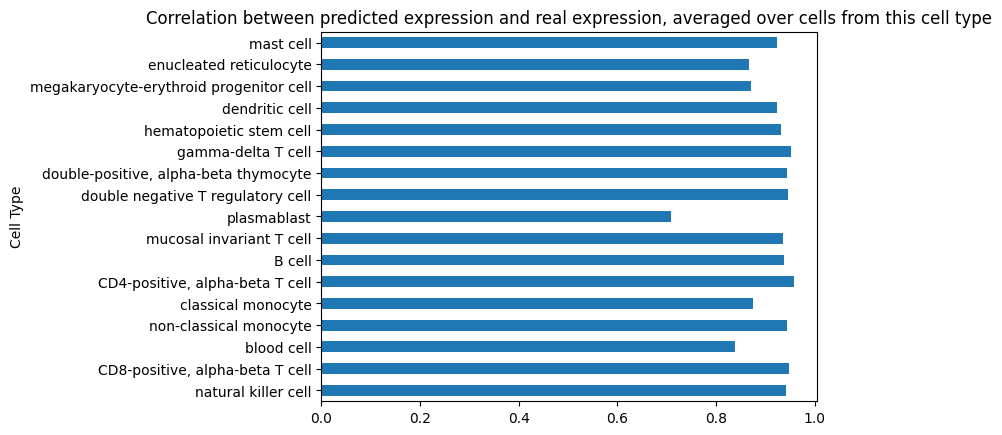

In [153]:
ax = ct_corr_df.rename(columns={0:"Cell Type"}).plot.barh(x="Cell Type")
plt.title("Correlation between predicted expression and real expression, averaged over cells from this cell type");
ax.get_legend().remove()